In [4]:
import numpy as np
import pandas as pd
import obspy

import matplotlib.pyplot as plt
import seaborn as sns

import pylab as pl
import time

from matplotlib.colors import ListedColormap
%matplotlib inline
plt.rcParams["figure.figsize"]= (15,15)


import sys
import os
ISCOLAB = 'google.colab' in sys.modules

import random
import json
import pprint
from obspy import Stream, Trace, UTCDateTime
sns.set(style='white', context='notebook', rc={'figure.figsize':(14,10)})

base_dir = 'C:\Documents\Thesis_ssd\MasterThesis-2.0'
os.chdir(base_dir)

from Classes.DataProcessing.LoadData import LoadData
from Classes.DataProcessing.BaselineHelperFunctions import BaselineHelperFunctions
from Classes.DataProcessing.DataHandler import DataHandler
from Classes.DataProcessing.DataGenerator import DataGenerator
from Classes.Modeling.Models import Models
from Classes.Modeling.RandomGridSearch import RandomGridSearch
from Classes.Modeling.CustomCallback import CustomCallback
from Classes.Scaling.ScalerFitter import ScalerFitter
from Classes.Scaling.MinMaxScalerFitter import MinMaxScalerFitter
from Classes.Scaling.StandardScalerFitter import StandardScalerFitter



In [11]:
csv_root = 'csv_folder/2_class'
loadData = LoadData(csv_root, isBalanced = True)
shuffle = False
full_ds, train_ds, val_ds, test_ds = loadData.getDatasets(shuffle = shuffle)
handler = DataHandler(csv_root)
pp = pprint.PrettyPrinter(indent=4)
helper = BaselineHelperFunctions()

## Distributions:

In [172]:
def get_all_earthquakes(ds):
    earthquakes = []
    for path, label in ds:
        if label == 'earthquake':
            earthquakes.append([path, label])
    return np.array(earthquakes)

def get_magnitudes(ds):
    path_label_mag = []
    for path, label in ds:
        if label == "noise":
            continue
        mag = handler.path_to_trace(path)[1].get('magnitudes')[0]['mag']
        path_label_mag.append([path, label, mag])
    return np.array(path_label_mag)

def get_mag_counts_rounded(path_label_mag, decimals):
    path_label_mag_rounded = path_label_mag
    for idx, plm in enumerate(path_label_mag_rounded):
        path_label_mag_rounded[idx][2] = np.round(float(plm[2]), decimals=decimals)
    intervals = [i/10**(decimals) for i in range(0, 10**(decimals+1) +1)]
    interval_count = []
    for interval in intervals:
        current_count = 0
        for path, label, mag in path_label_mag_rounded:
            if float(mag) == interval:
                current_count += 1
        interval_count.append([interval, current_count])
    return np.array(interval_count)
                
        

In [132]:
path_label_mag = get_magnitudes(train_ds)


In [173]:
rounded_mags = get_mag_counts_rounded(path_label_mag, 1)

In [174]:
print(rounded_mags)

[[  0.00000000e+00   0.00000000e+00]
 [  1.00000000e-01   0.00000000e+00]
 [  2.00000000e-01   0.00000000e+00]
 [  3.00000000e-01   0.00000000e+00]
 [  4.00000000e-01   0.00000000e+00]
 [  5.00000000e-01   3.00000000e+00]
 [  6.00000000e-01   1.20000000e+01]
 [  7.00000000e-01   1.80000000e+01]
 [  8.00000000e-01   1.90000000e+01]
 [  9.00000000e-01   4.20000000e+01]
 [  1.00000000e+00   6.50000000e+01]
 [  1.10000000e+00   8.40000000e+01]
 [  1.20000000e+00   1.15000000e+02]
 [  1.30000000e+00   9.30000000e+01]
 [  1.40000000e+00   1.17000000e+02]
 [  1.50000000e+00   1.27000000e+02]
 [  1.60000000e+00   1.42000000e+02]
 [  1.70000000e+00   1.49000000e+02]
 [  1.80000000e+00   1.44000000e+02]
 [  1.90000000e+00   1.51000000e+02]
 [  2.00000000e+00   1.58000000e+02]
 [  2.10000000e+00   1.64000000e+02]
 [  2.20000000e+00   2.01000000e+02]
 [  2.30000000e+00   2.51000000e+02]
 [  2.40000000e+00   2.98000000e+02]
 [  2.50000000e+00   2.97000000e+02]
 [  2.60000000e+00   2.81000000e+02]
 

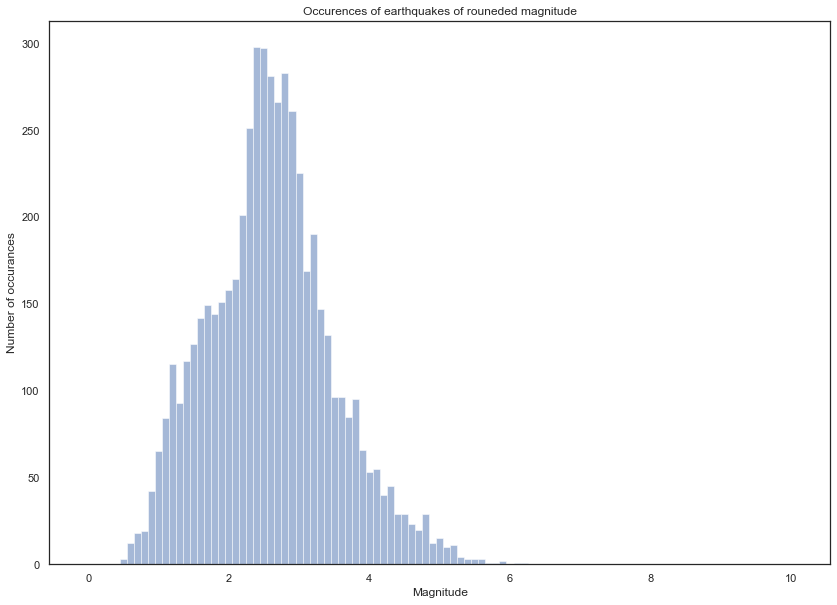

In [185]:
plt.bar(rounded_mags[:,0], rounded_mags[:,1], align='center', alpha=0.5, width=0.1)
plt.xlabel("Magnitude")
plt.ylabel("Number of occurances")
plt.title("Occurences of earthquakes of rouneded magnitude")

plt.show()

In [107]:
np.arange(0,10, (10**-1))

array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ,
        1.1,  1.2,  1.3,  1.4,  1.5,  1.6,  1.7,  1.8,  1.9,  2. ,  2.1,
        2.2,  2.3,  2.4,  2.5,  2.6,  2.7,  2.8,  2.9,  3. ,  3.1,  3.2,
        3.3,  3.4,  3.5,  3.6,  3.7,  3.8,  3.9,  4. ,  4.1,  4.2,  4.3,
        4.4,  4.5,  4.6,  4.7,  4.8,  4.9,  5. ,  5.1,  5.2,  5.3,  5.4,
        5.5,  5.6,  5.7,  5.8,  5.9,  6. ,  6.1,  6.2,  6.3,  6.4,  6.5,
        6.6,  6.7,  6.8,  6.9,  7. ,  7.1,  7.2,  7.3,  7.4,  7.5,  7.6,
        7.7,  7.8,  7.9,  8. ,  8.1,  8.2,  8.3,  8.4,  8.5,  8.6,  8.7,
        8.8,  8.9,  9. ,  9.1,  9.2,  9.3,  9.4,  9.5,  9.6,  9.7,  9.8,
        9.9])